<a href="https://colab.research.google.com/github/Yaswanthyarra/MicroexpressionClassificationUsingCNNandGeneticAlgorithm/blob/main/ResultsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/CASMEII'

/content/drive/My Drive/CASMEII


In [ ]:
dataset_dir = '/content/drive/My Drive/CASMEII/Cropped-updated/Cropped'

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# define constants
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_EPOCHS = 60

# load the onset and apex frame indices from the Excel sheet
coding_file = pd.read_excel('/content/drive/My Drive/CASMEII/CASME2-coding-20140508.xlsx', sheet_name='Sheet1')

class_labels = coding_file['Estimated Emotion'].values

# define a function to extract the onset and apex frames for each expression
def extract_frames(sequence_path,sequence, subject_num):
    expression_images = []

    #To obtain the onset and apex frame numbers for the given subject and the corresponding sequence from the xlsheet
    subject_data = coding_file.loc[coding_file['Subject'] == subject_num]
    sequence_data = subject_data.loc[subject_data['Filename'] == sequence]
    onset_frame = sequence_data['OnsetFrame'].iloc[0]
    apex_frame = sequence_data['ApexFrame'].iloc[0]
                                                                                                                                                                 
    #To obtain the path to frames corresponding to the apex and onset frame numbers from the sequence of frames for the subject
    onset_frame_path = os.path.join(sequence_path,'reg_img' + str(onset_frame) + '.jpg')
    apex_frame_path = os.path.join(sequence_path, 'reg_img' + str(apex_frame) + '.jpg')
    print(subject_num,apex_frame_path)
    print(subject_num,onset_frame_path)
   
    #To obtain the apex and apex frames from path
    onset_frame = cv2.imread(onset_frame_path)
    apex_frame = cv2.imread(apex_frame_path)
    onset_frame = cv2.cvtColor(onset_frame, cv2.COLOR_BGR2GRAY)
    apex_frame = cv2.cvtColor(apex_frame, cv2.COLOR_BGR2GRAY)
    
    #To apply histogram equalisation to the frames to to enhance the contrast of an image by redistributing the pixel intensities. 
    onset_frame = cv2.equalizeHist(onset_frame)
    apex_frame = cv2.equalizeHist(apex_frame)

    #Resizing extracted frames
    onset_frame = cv2.resize(onset_frame, IMAGE_SIZE)
    apex_frame = cv2.resize(apex_frame, IMAGE_SIZE)

    #Stacking the apex and onset frames together and and appending to the expressin images list
    expression_images.append(np.stack([onset_frame, apex_frame], axis=-1))
    
    return np.array(expression_images)

# create a data generator for the image data
data_generator = ImageDataGenerator(rescale=1./255)

#Setting up several image augmentation parameters that can be used to generate augmented images 
exp_frame_augmentation = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'brightness_range': [0.5, 1.5],
}


# load the expression folders and extract the onset and apex frames for each subject

#converting the categorical class labels of a classification problem into numerical form
label_dict = {'happiness': 0, 'disgust': 1, 'repression': 2, 'surprise': 3, 'fear': 4, 'others': 6,'sadness':5}

expression_images = []
expression_labels = []

#Looping through all the subjects in the dataset
for subject in os.listdir(dataset_dir):

    subject_num = int(subject[3:])
    subject_dir = os.path.join(dataset_dir, subject)

    #Looping through each sequence for the subject
    for sequence in os.listdir(subject_dir):
        
        sequence_path = os.path.join(subject_dir, sequence)

        #Extracting the onset and apex frames by invoking the extract_frames method
        expression_frames = extract_frames(sequence_path, sequence, subject_num)

        #Obtaining the expression label for the sequence from the xlsheet and appending it to expression_label 
        subject_data = coding_file.loc[coding_file['Subject'] == subject_num]
        sequence_data = subject_data.loc[subject_data['Filename'] == sequence]
        exp_label_category = sequence_data['Estimated Emotion']
        expression_label = label_dict[exp_label_category.values[0]]

        #Adding the extracted frames and the correspoing class label to expression_images and expression_labels
        expression_images.append(expression_frames)
        expression_labels.append(expression_label)

        # Generating augmented images for the fear class
        if expression_label == 4:  # if fear class
            
            for i in range(30):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              
              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)
        
        # Generating augmented images for the sadness class
        if expression_label == 5:  # if sadness class
           
            for i in range(9):
              print(i,subject_num)
              
              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  

        # generate augmented images for the happiness class
        if expression_label == 0:  # if happiness class
        
            for i in range(1):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              
              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  

        # Generate augmented images for the repression class
        if expression_label == 2:  # if repression class
          
            for i in range(1):
              print(i,subject_num)
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  
        
        # Generate augmented images for the surprise class
        if expression_label == 3:  # if surprise class
            
            
            for i in range(1):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  


        

        
# convert the data to numpy arrays 
expression_images = np.concatenate(expression_images, axis=0)
expression_labels = np.array(expression_labels)

#To obtain the number of class labels
num_classes = len(np.unique(expression_labels))

#Stratified Spliting of data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(expression_images, expression_labels, test_size=0.2,stratify=expression_labels,  random_state=42)



25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP09_02/reg_img101.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP09_02/reg_img76.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP10_01/reg_img129.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP10_01/reg_img101.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP03_01/reg_img81.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP03_01/reg_img56.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP03_02/reg_img101.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP03_02/reg_img51.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP10_10/reg_img91.jpg
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP10_10/reg_img61.jpg
0 25
25 /content/drive/My Drive/CASMEII/Cropped-updated/Cropped/sub25/EP18_04f/reg_img116.jpg
25 /content/drive/My Drive/CASME

In [56]:
from keras.optimizers import Adam
# define the model architecture
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.33),
    Dense(num_classes, activation='softmax')
])
optimizer = Adam(learning_rate=0.0005)
model1.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history1=model1.fit(train_images, train_labels, epochs=30, batch_size=64, validation_data=(test_images, test_labels))

# evaluate the model on the test set
test_loss, test_acc = model1.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/30
6/6 [==============================] - 4s 702ms/step - loss: 29.6653 - accuracy: 0.1436 - val_loss: 6.8071 - val_accuracy: 0.2796
Epoch 2/30
6/6 [==============================] - 4s 586ms/step - loss: 4.2423 - accuracy: 0.2493 - val_loss: 1.7169 - val_accuracy: 0.3011
Epoch 3/30
6/6 [==============================] - 3s 435ms/step - loss: 1.8180 - accuracy: 0.2493 - val_loss: 1.6214 - val_accuracy: 0.3978
Epoch 4/30
6/6 [==============================] - 3s 467ms/step - loss: 1.6308 - accuracy: 0.3631 - val_loss: 1.5502 - val_accuracy: 0.4301
Epoch 5/30
6/6 [==============================] - 3s 439ms/step - loss: 1.5532 - accuracy: 0.3930 - val_loss: 1.4257 - val_accuracy: 0.4624
Epoch 6/30
6/6 [==============================] - 4s 757ms/step - loss: 1.4588 - accuracy: 0.4092 - val_loss: 1.3445 - val_accuracy: 0.5269
Epoch 7/30
6/6 [==============================] - 3s 484ms/step - loss: 1.4362 - accuracy: 0.4472 - val_loss: 1.3115 - val_accuracy: 0.5161
Epoch 8/30
6/6 [===

In [57]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set using model3
predictions = model1.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, F1-score, and support
report = classification_report(test_labels, predicted_labels, zero_division=0, output_dict=True)

# Extract the metrics from the report
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
precision = report['weighted avg']['precision']
uar = report['macro avg']['recall']
uf1 = report['macro avg']['f1-score']

# Print the metrics
print('Test accuracy:', test_accuracy)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Precision:', precision)
print('UAR:', uar)
print('UF1 accuracy:', uf1)

3/3 [==============================] - 0s 59ms/step
Test accuracy: 0.7634408602150538
Recall: 0.7634408602150538
F1-score: 0.7359839142012572
Precision: 0.7930555555555555
UAR: 0.7516483516483516
UF1 accuracy: 0.7306037291044787


3/3 [==============================] - 0s 57ms/step


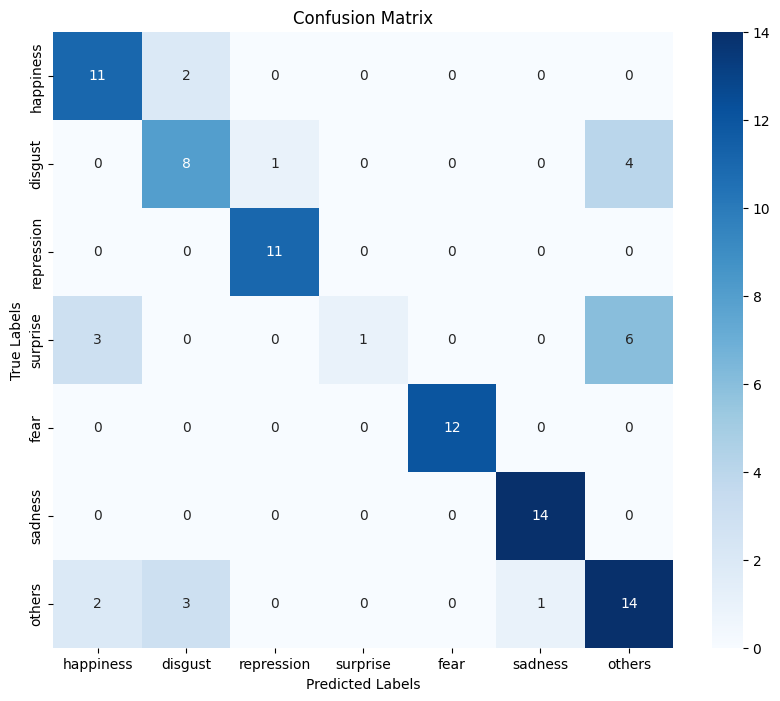

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set using model3
predictions = model1.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Define the label names
label_names = ['happiness', 'disgust', 'repression', 'surprise', 'fear', 'sadness', 'others']

# Plot confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
#Using Optimised hyperparameters by genetic algorithm
#[0.0006651508397586441, 17.841842195711813, 0.29999999999999993, 52.73272478423032]
from keras.optimizers import Adam
# define the model architecture
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.29999999999999993),
    Dense(num_classes, activation='softmax')
])
optimizer = Adam(learning_rate=0.0006651508397586441)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2=model2.fit(train_images, train_labels, epochs=52, batch_size=17, validation_data=(test_images, test_labels))

# evaluate the model on the test set
test_loss, test_acc = model2.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_acc)


Epoch 1/52
22/22 [==============================] - 4s 152ms/step - loss: 19.3227 - accuracy: 0.1545 - val_loss: 1.8240 - val_accuracy: 0.2688
Epoch 2/52
22/22 [==============================] - 3s 134ms/step - loss: 1.7982 - accuracy: 0.2818 - val_loss: 1.5842 - val_accuracy: 0.4516
Epoch 3/52
22/22 [==============================] - 3s 134ms/step - loss: 1.5274 - accuracy: 0.4444 - val_loss: 1.3121 - val_accuracy: 0.6022
Epoch 4/52
22/22 [==============================] - 4s 176ms/step - loss: 1.2946 - accuracy: 0.5176 - val_loss: 1.0464 - val_accuracy: 0.6774
Epoch 5/52
22/22 [==============================] - 4s 180ms/step - loss: 1.1070 - accuracy: 0.5962 - val_loss: 0.8777 - val_accuracy: 0.7527
Epoch 6/52
22/22 [==============================] - 3s 135ms/step - loss: 0.8816 - accuracy: 0.6612 - val_loss: 0.8397 - val_accuracy: 0.6774
Epoch 7/52
22/22 [==============================] - 3s 129ms/step - loss: 0.8438 - accuracy: 0.6829 - val_loss: 0.6764 - val_accuracy: 0.7527
Epoch

In [67]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set using model3
predictions = model2.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, F1-score, and support
report = classification_report(test_labels, predicted_labels, zero_division=0, output_dict=True)

# Extract the metrics from the report
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
precision = report['weighted avg']['precision']
uar = report['macro avg']['recall']
uf1 = report['macro avg']['f1-score']

# Print the metrics
print('Test accuracy:', test_accuracy)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Precision:', precision)
print('UAR:', uar)
print('UF1 accuracy:', uf1)

3/3 [==============================] - 1s 179ms/step
Test accuracy: 0.8924731182795699
Recall: 0.8924731182795699
F1-score: 0.8902393948146792
Precision: 0.8905832518735745
UAR: 0.9093406593406593
UF1 accuracy: 0.9018749123331419


3/3 [==============================] - 0s 100ms/step


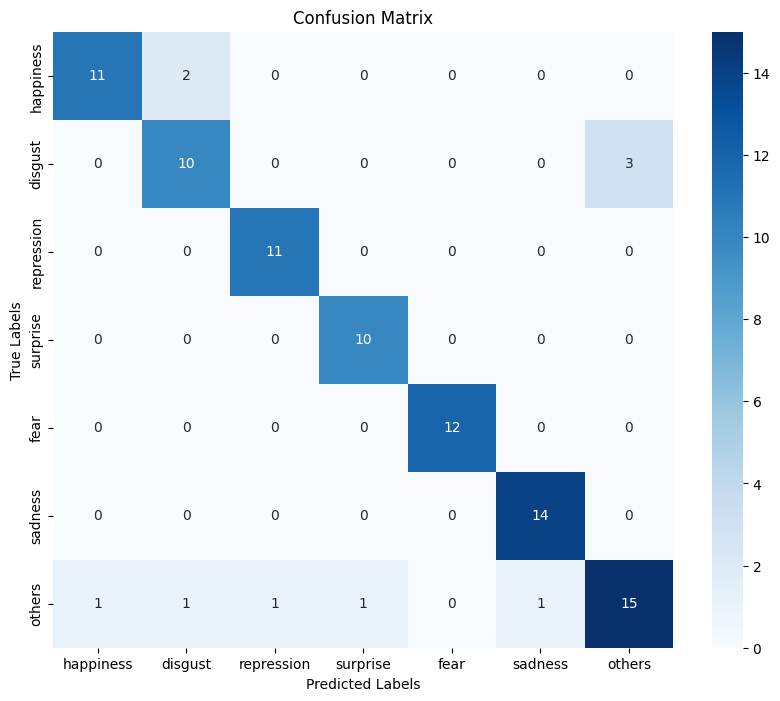

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set using model3
predictions = model2.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Define the label names
label_names = ['happiness', 'disgust', 'repression', 'surprise', 'fear', 'sadness', 'others']

# Plot confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
#Using Optimised hyperparameters by Random Search
#{'learning_rate': 0.001, 'epochs': 60, 'dropout_rate': 0.3, 'batch_size': 64}
from keras.optimizers import Adam
# define the model architecture
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history3=model3.fit(train_images, train_labels, epochs=60, batch_size=64, validation_data=(test_images, test_labels))

# evaluate the model on the test set
test_loss, test_acc = model3.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/60
6/6 [==============================] - 4s 517ms/step - loss: 41.6380 - accuracy: 0.1463 - val_loss: 5.0863 - val_accuracy: 0.1398
Epoch 2/60
6/6 [==============================] - 3s 531ms/step - loss: 4.0106 - accuracy: 0.1436 - val_loss: 1.9600 - val_accuracy: 0.1935
Epoch 3/60
6/6 [==============================] - 5s 737ms/step - loss: 1.9563 - accuracy: 0.1897 - val_loss: 1.8111 - val_accuracy: 0.3441
Epoch 4/60
6/6 [==============================] - 3s 445ms/step - loss: 1.8017 - accuracy: 0.2710 - val_loss: 1.7620 - val_accuracy: 0.4409
Epoch 5/60
6/6 [==============================] - 3s 434ms/step - loss: 1.7488 - accuracy: 0.3062 - val_loss: 1.6075 - val_accuracy: 0.4086
Epoch 6/60
6/6 [==============================] - 3s 437ms/step - loss: 1.6777 - accuracy: 0.3198 - val_loss: 1.5883 - val_accuracy: 0.4946
Epoch 7/60
6/6 [==============================] - 4s 667ms/step - loss: 1.6270 - accuracy: 0.3306 - val_loss: 1.4561 - val_accuracy: 0.5054
Epoch 8/60
6/6 [===

In [49]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set using model3
predictions = model3.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, F1-score, and support
report = classification_report(test_labels, predicted_labels, zero_division=0, output_dict=True)

# Extract the metrics from the report
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
precision = report['weighted avg']['precision']
uar = report['macro avg']['recall']
uf1 = report['macro avg']['f1-score']

# Print the metrics
print('Test accuracy:', test_accuracy)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Precision:', precision)
print('UAR:', uar)
print('UF1 accuracy:', uf1)

3/3 [==============================] - 0s 62ms/step
Test accuracy: 0.8602150537634409
Recall: 0.8602150537634409
F1-score: 0.858588706737813
Precision: 0.8691529011479924
UAR: 0.8646853146853147
UF1 accuracy: 0.8693831429196305


3/3 [==============================] - 0s 99ms/step


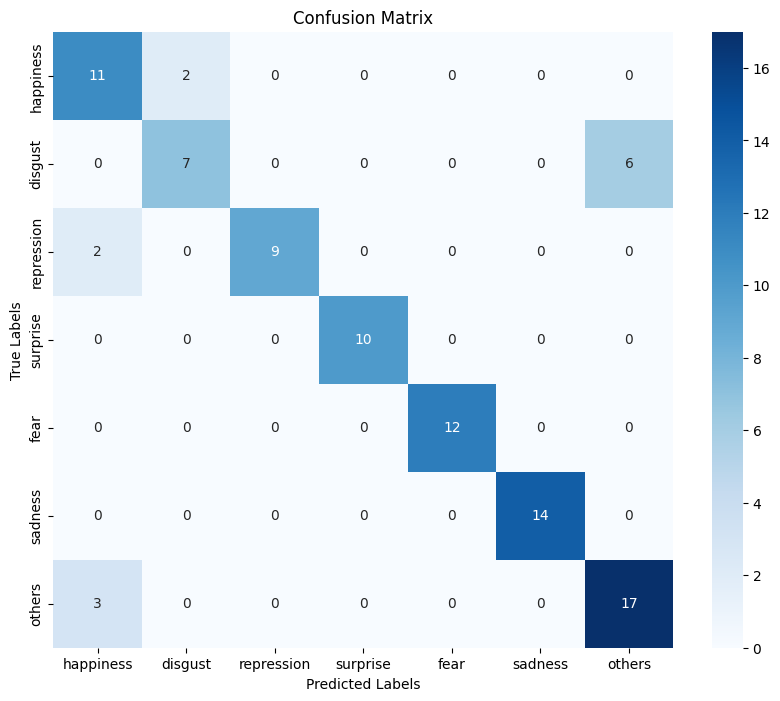

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set using model3
predictions = model3.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Define the label names
label_names = ['happiness', 'disgust', 'repression', 'surprise', 'fear', 'sadness', 'others']

# Plot confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


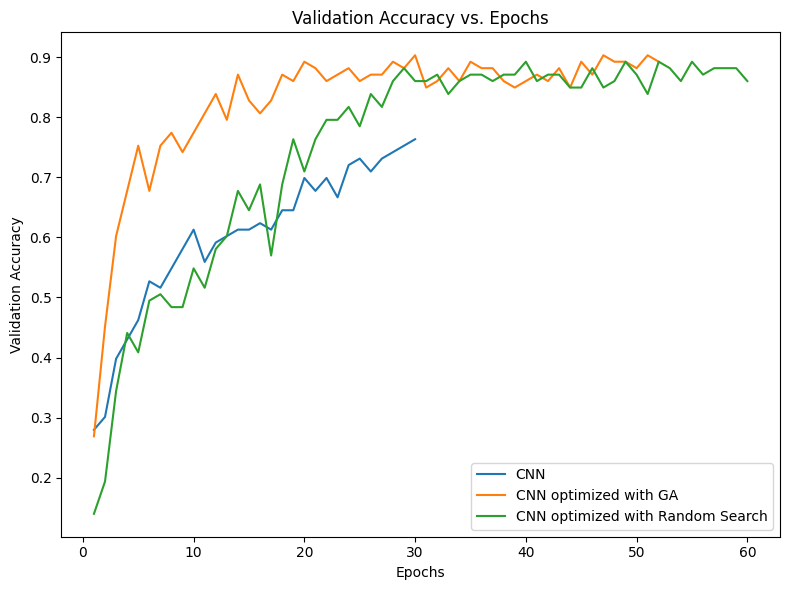

In [65]:
import matplotlib.pyplot as plt

# Extract the validation accuracy values from the training history for all three models
val_accuracy1 = history1.history['val_accuracy']
val_accuracy2 = history2.history['val_accuracy']
val_accuracy3 = history3.history['val_accuracy']

# Plot validation accuracy vs. epochs for all three models
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy1) + 1), val_accuracy1, label='CNN')
plt.plot(range(1, len(val_accuracy2) + 1), val_accuracy2, label='CNN optimized with GA')
plt.plot(range(1, len(val_accuracy3) + 1), val_accuracy3, label='CNN optimized with Random Search')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()